# Initialiazation Packages

In [1]:
using LinearAlgebra
using PyPlot
using PyCall
using LaTeXStrings
using QuantumToolbox
using DelimitedFiles, NLsolve
using Random, Distributions, Dates, Polynomials, StatsBase 
using JLD

In [2]:
using Pkg
Pkg.activate("..")

include("../src/Closed_2KPOs_QTB_functions.jl")
using .Coupled_KPOs_QTB_functions

  Activating project at `c:\Users\edson\Desktop\Research\Kerr_system\Coupled_KPOs`


### Entanglement Entropy
Measures the degree of entanglement between two subsystems, KPO1 and KPO2 in our case. Given a state from its density matrix ρ, we trace out KPO2 to obtain the reduced density matrix ρ_1=Tr_2 (ρ). The entanglement entropy is 


$$S_{1} = \sum_{n} \lambda_{n} \log{\lambda_{n}}$$


Where $\{ \lambda_{n} \}$ are the eigenvalues of $\rho_{1}$.   
Reference values:  
	- Fully chaotic state (max entangled): Page average entanglement entropy: 
$$S_{Page}=\sum_{k=d_B+1}^{d_A, d_B} k- \frac{d_A- 1}{(2d_B } ≈ \ln{d_{A}}⁡ - \frac{d_A}{2d_B}$$
For $d_A=d_B=100, S_Page=4.1052$.  
Product random state: $S_1=0$.  
Bell states of coherent states of the fixed points gives $S_1= \ln{2} \approx 0.6931875382925285$


## Uncoupled GS evolution

In [5]:
println("Loading defnitions")
N = 100
p = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ =  0., 1., 0., 5., 0., 1., 0., 5.,1.
Neff = 1
N_states=4000
Entroy_sum = zeros(N);
println("Done")

Loading defnitions
Done


In [15]:
println("Diagonalization for time evolution")
println("Fock size N = $(N)^2")
t = time()
E_S_even, ψ_S_even, E_A_even, ψ_A_even, E_S_odd, ψ_S_odd, E_A_odd, ψ_A_odd = Coupled_kerr_equiv(p, N);
#Organizing 
all_energies = vcat(real.(E_S_even), real.(E_A_even), real.(E_S_odd), real.(E_A_odd));
all_states = hcat(ψ_S_even, ψ_A_even, ψ_S_odd, ψ_A_odd);
# Get sorting indices for energies (ascending order)
sorted_indices = sortperm(all_energies);
E = all_energies[sorted_indices];
ψ = all_states[:, sorted_indices];
N_states = 4000 #From Convergence test
#Fixing states below E = 0 (saddle point at (0,0,0,0))
E = E[1:N_states];
ψ = ψ[:,1:N_states];
println("time for Diagonalization: $(round((time()-t)/60, digits=3))")
println("Done")

Diagonalization for time evolution
Fock size N = 100^2
time for Diagonalization: 1.439
Done


In [37]:
println("Time interval definitions")
t_final,t_step = 0.1, 100
t_interval = range(0.0, t_final, length=t_step)
println("Evolution until t = $(t_final)/K in t_step = $(t_step)")
println("Done")

Time interval definitions
Evolution until t = 0.1/K in t_step = 100
Done


In [38]:
println("Preparing output registers")
PR_unc = zeros(length(t_interval));
Entropy = zeros(length(t_interval));
n1, n2 = zeros(length(t_interval)), zeros(length(t_interval));
println("Done")

Preparing output registers
Done


In [39]:
println("Preparing the Initial Condition from Uncoupled GS")
#Uncoupled KPOs
E_unc, ψ_unc = H_un(p, N);
E_0s, ψ_0s = H_un(p, N, n_states = 2);
println("We choose GS | C_+ C_+ ⟩ as IC")
ψ_0, E_0 = ψ_0s[:,1], E_0s[1] 
println("Done")

println("Calculating the observable for the IC")
PR_unc[1] = 1.
n1_ = repeat(0:N-1, inner=N)
n1[1] = sum(abs2.(ψ_0) .* n1_)
n2_ = repeat(0:N-1, outer=N)
n2[1] = sum(abs2.(ψ_0) .* n2_)
Entropy[1] = 0.
println("Done")


Preparing the Initial Condition from Uncoupled GS
We choose GS | C_+ C_+ ⟩ as IC
Done
Calculating the observable for the IC
Done


In [40]:
println("Begin evolution")
t = time()
for k in 2:length(t_interval)
    #Evolution trhough eigenbasis
    c_j = (ψ' * ψ_0) .* exp.(-1im*E*t_interval[k]) 
    ψ_cj = ψ .* conj(c_j)'
    ψ_t = sum(ψ_cj, dims=2)
    
    ψ_t = vec(ψ_t)
    PR_unc[k] = ( 1 / sum(abs.(ψ_unc' * ψ_t).^4, dims=1))[1] 
    n1_ = repeat(0:N-1, inner=N)
    n1[k] = sum(abs2.(ψ_t) .* n1_)
    n2_ = repeat(0:N-1, outer=N)
    n2[k] = sum(abs2.(ψ_t) .* n2_)
    Entropy[k] = Coupled_KPOs_QTB_functions.Entanglement_entropy_fock(ψ_t, N)
end
println("Time elapsed for evolution: $(round((time() - t)/60, digits=3) )min")

Begin evolution
Time elapsed for evolution: 0.456min


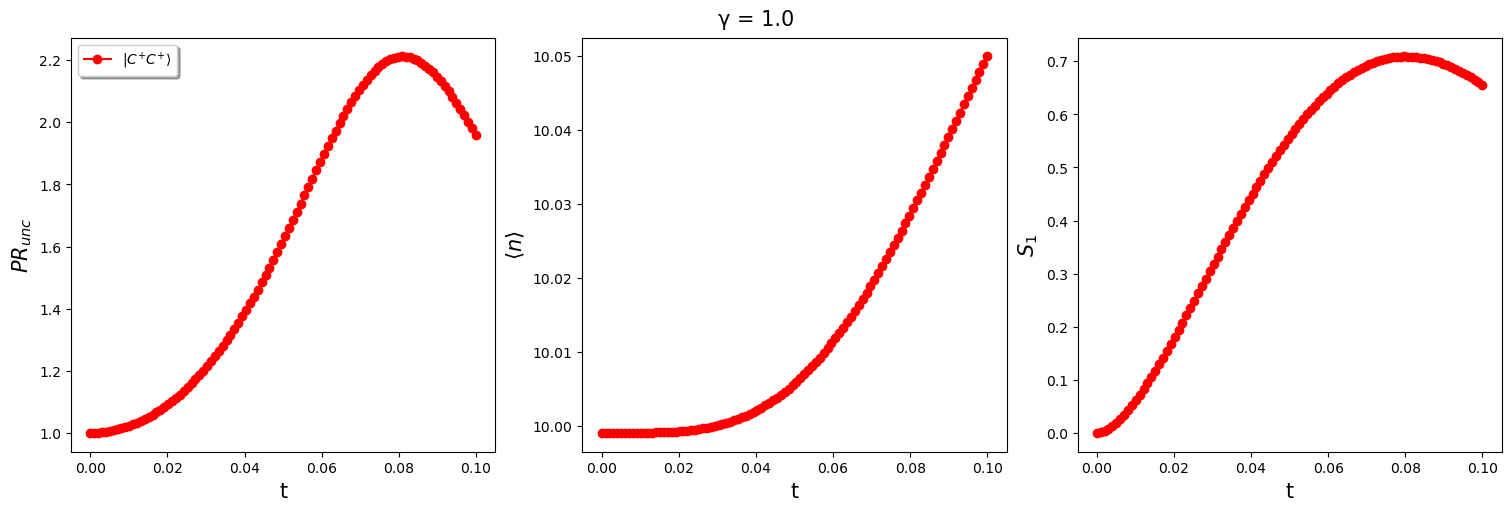

In [41]:
fig = figure(figsize=(15,5), layout= "constrained");
gs = fig.add_gridspec(1,3);
element(i,j) = get(gs, (i,j)); # starts at 0 to N-1
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j);

colors_ = ["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"];
labels_ = Coupled_KPOs_QTB_functions.labels_states_KPOs(2);
markers_ = ["o", "v", "s", "D", "^", "<", ">", "p", "*", "h"];
labels_plots = [L"PR_{unc}", L"⟨n⟩", L"S_{1}"]
plots_list = [PR_unc, n1 .+ n2, Entropy] 

for i in 1:3
    ax = fig.add_subplot(element(0,i-1));
    plot(t_interval, plots_list[i], marker = markers_[1], color=colors_[1], label = labels_[1])
    
    if i == 1
        legend(fontsize=10, shadow=true, loc = "upper left");
    end
    ylabel(labels_plots[i], fontsize=15);
    xlabel("t", fontsize=15);
    
end
fig.suptitle("γ = $(p[9])", fontsize=15);
#savefig("C:/Users/edson/Desktop/Research/Kerr_system/Coupled_kerr/codes_Chemistry/Quantum_figures/Scrambling/PR_unc_N_$(N)_p_$(p)_n_qudits_$(n_qudits).png")

#=
fig2 = figure(figsize=(15,5), layout= "constrained");
gs2 = fig2.add_gridspec(1,3);
element(i,j) = get(gs2, (i,j)); # starts at 0 to N-1
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j);

for i in 1:3
    ax = fig2.add_subplot(element(0,i-1));
    plot(t_interval .* p[9], plots_list[i], marker = markers_[1], color=colors_[1], label = labels_[1])
    
    if i == 1
        legend(fontsize=10, shadow=true, loc = "upper left");
    end
    ylabel(labels_plots[i], fontsize=15);
    xlabel("t γ", fontsize=15);
end
=#

### Three time intervals $t_{f} = 0.1, 1., 10$

In [42]:
ts_final = [0.1, 1., 10]
t_step = 100
PRs_unc = [zeros(t_step) for i in 1:length(ts_final)];
Entropies = [zeros(t_step) for i in 1:length(ts_final)];
ns = [zeros(t_step) for i in 1:length(ts_final)]

for j in 1:length(ts_final)
    println("Time interval definitions for index $(j)")
    t_final = ts_final[j]
    t_interval = range(0.0, t_final, length=t_step)
    println("Evolution until t = $(t_final)/K in t_step = $(t_step)")
    println("Done")

    println("Preparing output registers")
    n1, n2 = zeros(length(t_interval)), zeros(length(t_interval));
    println("Done")

    println("Preparing the Initial Condition from Uncoupled GS")
    #Uncoupled KPOs
    E_unc, ψ_unc = H_un(p, N);
    E_0s, ψ_0s = H_un(p, N, n_states = 2);
    println("We choose GS | C_+ C_+ ⟩ as IC")
    ψ_0, E_0 = ψ_0s[:,1], E_0s[1] 
    println("Done")

    println("Calculating the observable for the IC")
    PRs_unc[j][1] = 1.
    n1_ = repeat(0:N-1, inner=N)
    n1[1] = sum(abs2.(ψ_0) .* n1_)
    n2_ = repeat(0:N-1, outer=N)
    n2[1] = sum(abs2.(ψ_0) .* n2_)
    Entropies[j][1] = 0.
    println("Done")

    println("Begin evolution")
    t = time()
    for k in 2:length(t_interval)
        #Evolution trhough eigenbasis
        c_j = (ψ' * ψ_0) .* exp.(-1im*E*t_interval[k]) 
        ψ_cj = ψ .* conj(c_j)'
        ψ_t = sum(ψ_cj, dims=2)
        
        ψ_t = vec(ψ_t)
        PRs_unc[j][k] = ( 1 / sum(abs.(ψ_unc' * ψ_t).^4, dims=1))[1] 
        n1_ = repeat(0:N-1, inner=N)
        n1[k] = sum(abs2.(ψ_t) .* n1_)
        n2_ = repeat(0:N-1, outer=N)
        n2[k] = sum(abs2.(ψ_t) .* n2_)
        Entropies[j][k] = Coupled_KPOs_QTB_functions.Entanglement_entropy_fock(ψ_t, N)
    end
    ns[j] = n1 .+ n2
    println("Time elapsed for evolution: $(round((time() - t)/60, digits=3) )min")
end

Time interval definitions for index 1
Evolution until t = 0.1/K in t_step = 100
Done
Preparing output registers
Done
Preparing the Initial Condition from Uncoupled GS
We choose GS | C_+ C_+ ⟩ as IC
Done
Calculating the observable for the IC
Done
Begin evolution
Time elapsed for evolution: 0.461min
Time interval definitions for index 2
Evolution until t = 1.0/K in t_step = 100
Done
Preparing output registers
Done
Preparing the Initial Condition from Uncoupled GS
We choose GS | C_+ C_+ ⟩ as IC
Done
Calculating the observable for the IC
Done
Begin evolution
Time elapsed for evolution: 0.428min
Time interval definitions for index 3
Evolution until t = 10.0/K in t_step = 100
Done
Preparing output registers
Done
Preparing the Initial Condition from Uncoupled GS
We choose GS | C_+ C_+ ⟩ as IC
Done
Calculating the observable for the IC
Done
Begin evolution
Time elapsed for evolution: 0.441min


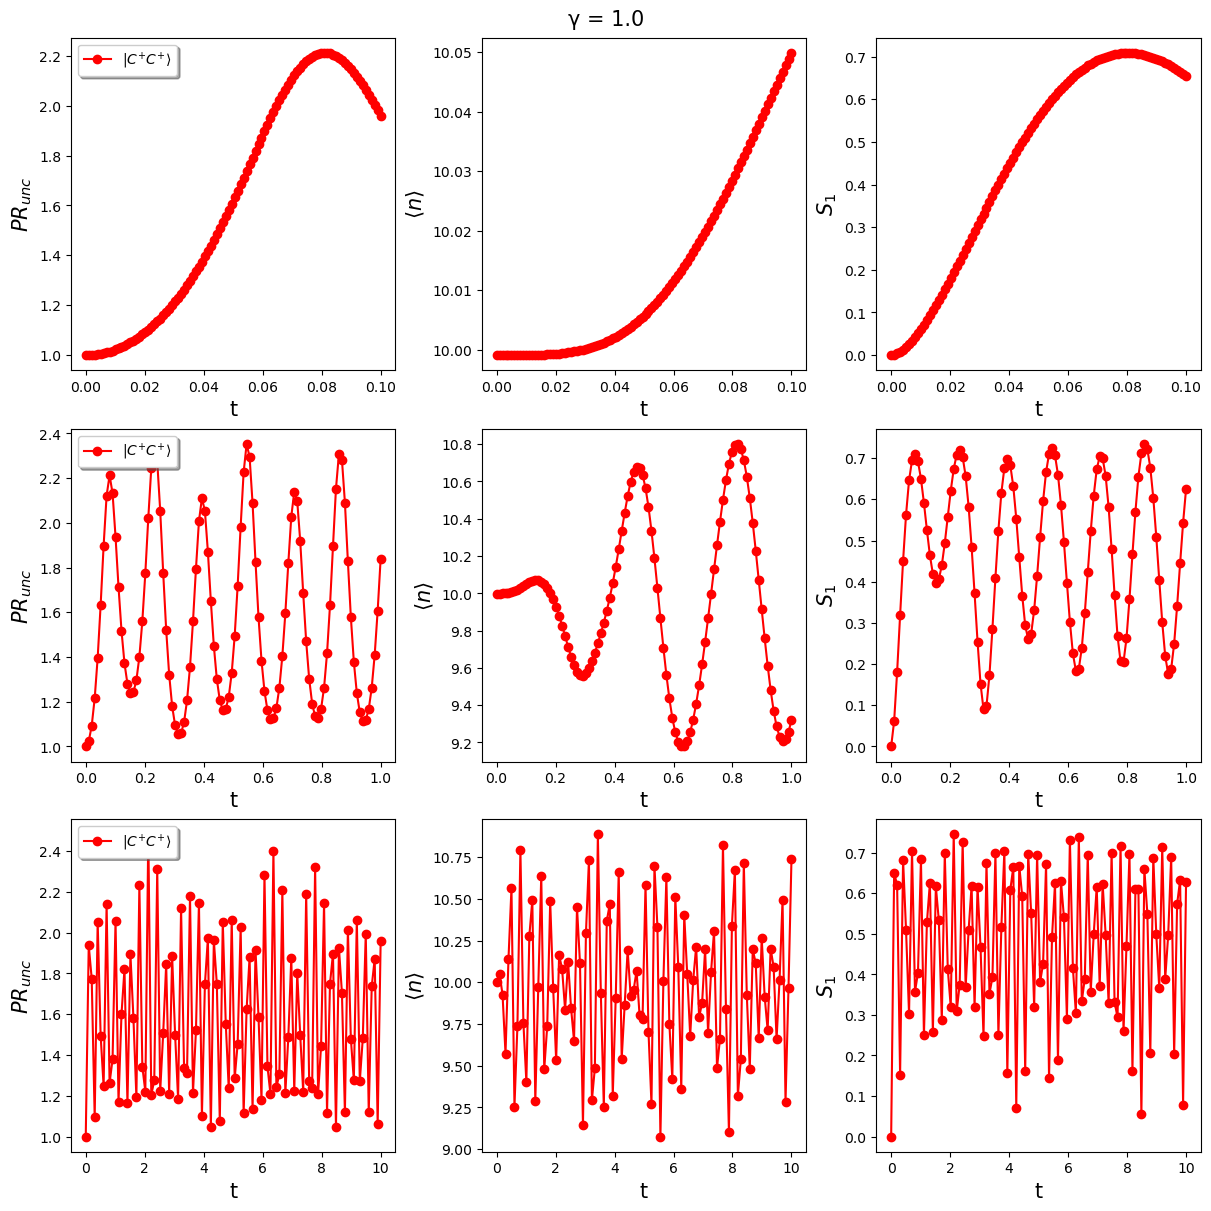

In [47]:
fig = figure(figsize=(12,12), layout= "constrained");
gs = fig.add_gridspec(length(ts_final),3);
element(i,j) = get(gs, (i,j)); # starts at 0 to N-1
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j);

colors_ = ["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"];
labels_ = Coupled_KPOs_QTB_functions.labels_states_KPOs(2);
markers_ = ["o", "v", "s", "D", "^", "<", ">", "p", "*", "h"];
labels_plots = [L"PR_{unc}", L"⟨n⟩", L"S_{1}"]
plots_list = [PRs_unc, ns, Entropies] 

for j in 1:length(ts_final)
    for i in 1:3
        ax = fig.add_subplot(element(j-1,i-1));
        plot(range(0.0, ts_final[j], length=t_step), plots_list[i][j], marker = markers_[1], color=colors_[1], label = labels_[1])
        
        if i == 1
            legend(fontsize=10, shadow=true, loc = "upper left");
        end
        ylabel(labels_plots[i], fontsize=15);
        xlabel("t", fontsize=15);
    end
end
fig.suptitle("γ = $(p[9])", fontsize=15);
#savefig("C:/Users/edson/Desktop/Research/Kerr_system/Coupled_kerr/codes_Chemistry/Quantum_figures/Scrambling/PR_unc_N_$(N)_p_$(p)_n_qudits_$(n_qudits).png")

### Sweeping coupling $\gamma = 0.1, 1., 2., 5.$

In [30]:
γs = [0.1, 1., 2., 5.]
t_step = 100
ts_final = [1., 5. ,10.]
PRs_unc_γ = [[zeros(t_step) for i in 1:length(ts_final)] for j in 1:length(γs)];
Entropies_γ = [[zeros(t_step) for i in 1:length(ts_final)] for j in 1:length(γs)];
ns_γ = [[zeros(t_step) for i in 1:length(ts_final)] for j in 1:length(γs)]

for l in 1:length(γs)
    println("Loading defnitions")
    N = 100
    p = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ =  0., 1., 0., 5., 0., 1., 0., 5., γs[l]
    Neff = 1
    N_states=4000
    Entroy_sum = zeros(N);
    println("Done")
    println("Diagonalization for time evolution")
    println("Fock size N = $(N)^2")
    t = time()
    E_S_even, ψ_S_even, E_A_even, ψ_A_even, E_S_odd, ψ_S_odd, E_A_odd, ψ_A_odd = Coupled_kerr_equiv(p, N);
    #Organizing 
    all_energies = vcat(real.(E_S_even), real.(E_A_even), real.(E_S_odd), real.(E_A_odd));
    all_states = hcat(ψ_S_even, ψ_A_even, ψ_S_odd, ψ_A_odd);
    # Get sorting indices for energies (ascending order)
    sorted_indices = sortperm(all_energies);
    E = all_energies[sorted_indices];
    ψ = all_states[:, sorted_indices];
    N_states = 4000 #From Convergence test
    #Fixing states below E = 0 (saddle point at (0,0,0,0))
    E = E[1:N_states];
    ψ = ψ[:,1:N_states];
    println("time for Diagonalization: $(round((time()-t)/60, digits=3))min")
    println("Done")


    for j in 1:length(ts_final)
        println("Time interval definitions for index $(j)")
        t_final = ts_final[j]
        t_interval = range(0.0, t_final, length=t_step)
        println("Evolution until t = $(t_final)/K in t_step = $(t_step)")
        println("Done")

        println("Preparing output registers")
        n1, n2 = zeros(length(t_interval)), zeros(length(t_interval));
        println("Done")

        println("Preparing the Initial Condition from Uncoupled GS")
        #Uncoupled KPOs
        E_unc, ψ_unc = H_un(p, N);
        E_0s, ψ_0s = H_un(p, N, n_states = 2);
        println("We choose GS | C_+ C_+ ⟩ as IC")
        ψ_0, E_0 = ψ_0s[:,1], E_0s[1] 
        println("Done")

        println("Calculating the observable for the IC")
        PRs_unc_γ[l][j][1] = 1.
        n1_ = repeat(0:N-1, inner=N)
        n1[1] = sum(abs2.(ψ_0) .* n1_)
        n2_ = repeat(0:N-1, outer=N)
        n2[1] = sum(abs2.(ψ_0) .* n2_)
        Entropies_γ[l][j][1] = 0.
        println("Done")

        println("Begin evolution")
        t = time()
        for k in 2:length(t_interval)
            #Evolution trhough eigenbasis
            c_j = (ψ' * ψ_0) .* exp.(-1im*E*t_interval[k]) 
            ψ_cj = ψ .* conj(c_j)'
            ψ_t = sum(ψ_cj, dims=2)
            
            ψ_t = vec(ψ_t)
            PRs_unc_γ[l][j][k] = ( 1 / sum(abs.(ψ_unc' * ψ_t).^4, dims=1))[1] 
            n1_ = repeat(0:N-1, inner=N)
            n1[k] = sum(abs2.(ψ_t) .* n1_)
            n2_ = repeat(0:N-1, outer=N)
            n2[k] = sum(abs2.(ψ_t) .* n2_)
            Entropies_γ[l][j][k] = Coupled_KPOs_QTB_functions.Entanglement_entropy_fock(ψ_t, N)
        end
        ns_γ[l][j] = n1 .+ n2
        println("Time elapsed for evolution: $(round((time() - t)/60, digits=3) )min")
    end
end
#12 minutes
println("Saving data")
Entropies_γ = save("../data/Cat_dynamics/Entropy_p_$((Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22))_γs_t.jld", "Entropies_γ", Entropies_γ)
PRs_unc_γ = save("../data/Cat_dynamics/PR_unc_p_$((Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22))_γs_t.jld", "PRs_unc_γ", PRs_unc_γ)
ns_γ = save("../data/Cat_dynamics/ns_γ_$((Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22))_γs_t.jld", "ns_γ", ns_γ)
println("Done")

Loading defnitions
Done
Diagonalization for time evolution
Fock size N = 100^2
time for Diagonalization: 1.532min
Done
Time interval definitions for index 1
Evolution until t = 1.0/K in t_step = 100
Done
Preparing output registers
Done
Preparing the Initial Condition from Uncoupled GS
We choose GS | C_+ C_+ ⟩ as IC
Done
Calculating the observable for the IC
Done
Begin evolution
Time elapsed for evolution: 0.43min
Time interval definitions for index 2
Evolution until t = 5.0/K in t_step = 100
Done
Preparing output registers
Done
Preparing the Initial Condition from Uncoupled GS
We choose GS | C_+ C_+ ⟩ as IC
Done
Calculating the observable for the IC
Done
Begin evolution
Time elapsed for evolution: 0.41min
Time interval definitions for index 3
Evolution until t = 10.0/K in t_step = 100
Done
Preparing output registers
Done
Preparing the Initial Condition from Uncoupled GS
We choose GS | C_+ C_+ ⟩ as IC
Done
Calculating the observable for the IC
Done
Begin evolution
Time elapsed for evolu

Loading data
Final t available: [1.0, 5.0, 10.0]
Done


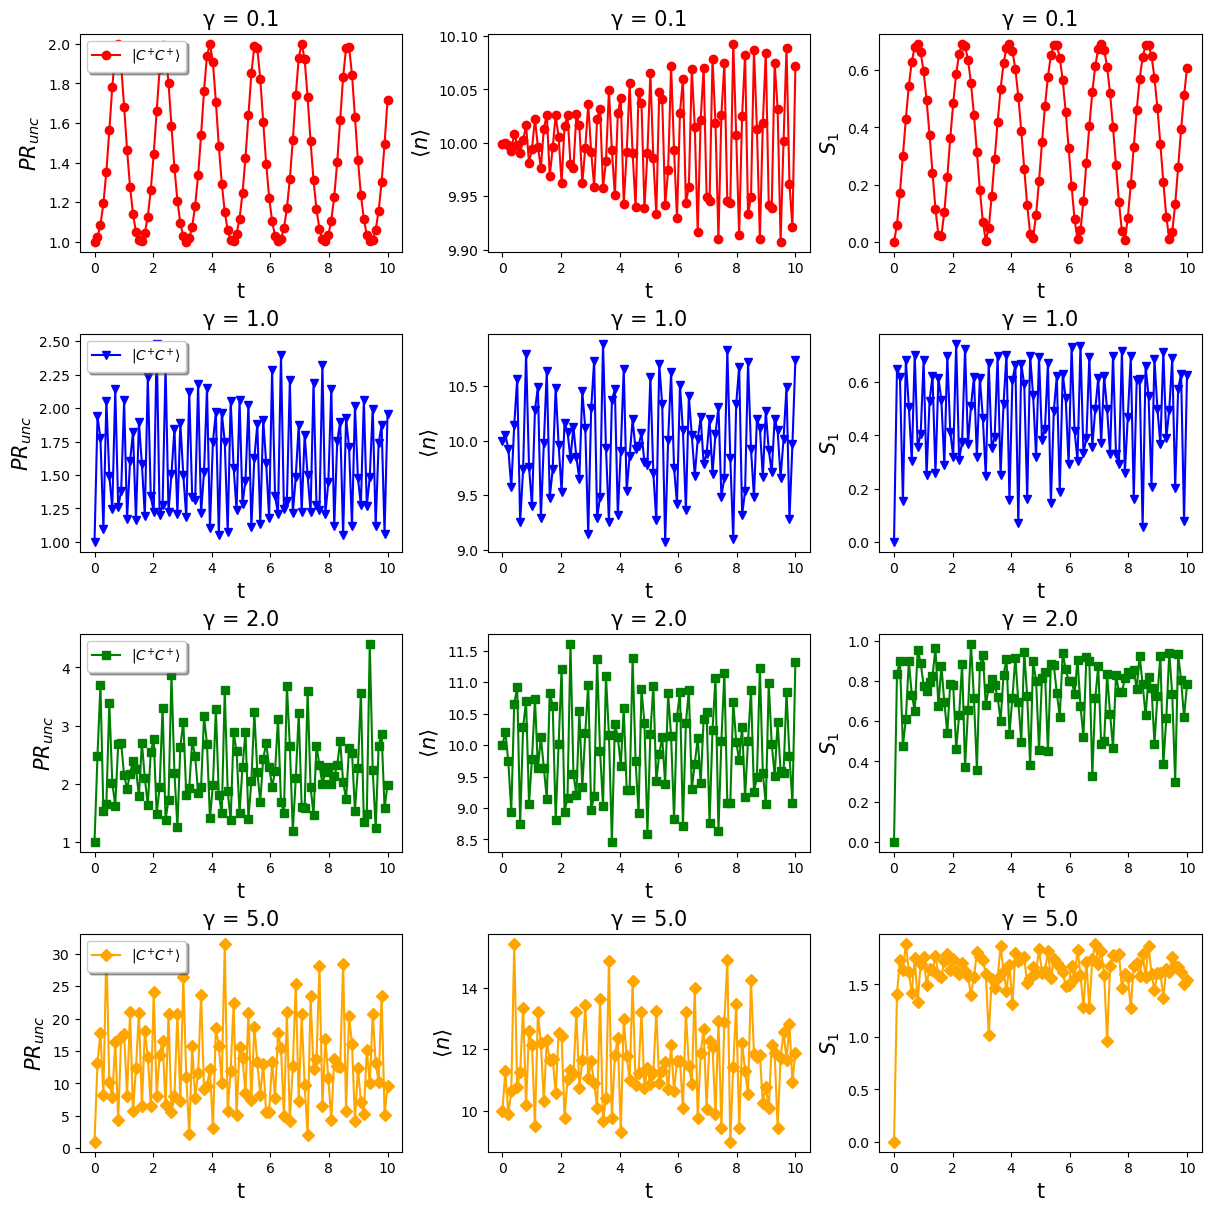

In [12]:
println("Loading data")
γs = [0.1, 1., 2., 5.]
ts_final =  [1., 5. ,10.]#These are τ = t * γ
println("Final t available: $(ts_final)")
t_step = 100
Entropies_γ = load("../data/Cat_dynamics/Entropy_p_$((Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22))_γs_t.jld")["Entropies_γ"]
PRs_unc_γ = load("../data/Cat_dynamics/PR_unc_p_$((Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22))_γs_t.jld")["PRs_unc_γ"]
ns_γ = load("../data/Cat_dynamics/ns_γ_$((Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22))_γs_t.jld")["ns_γ"]
println("Done")

fig = figure(figsize=(12,12), layout= "constrained");
gs = fig.add_gridspec(length(γs),3);
element(i,j) = get(gs, (i,j)); # starts at 0 to N-1
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j);

colors_ = ["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"];
labels_ = Coupled_KPOs_QTB_functions.labels_states_KPOs(2);
markers_ = ["o", "v", "s", "D", "^", "<", ">", "p", "*", "h"];
labels_plots = [L"PR_{unc}", L"⟨n⟩", L"S_{1}"]
plots_list = [PRs_unc_γ, ns_γ, Entropies_γ] 
t_index = 3
log_scale = false

for j in 1:length(γs)
    for i in 1:3
        ax = fig.add_subplot(element(j-1,i-1));
        plot(range(0.0, ts_final[t_index], length=t_step), plots_list[i][j][t_index], marker = markers_[j], color=colors_[j], label = labels_[1])
        if i == 1
            legend(fontsize=10, shadow=true, loc = "upper left");
        end
        if log_scale == true
            xscale("log")
            yscale("log")
            ylabel( "log("* labels_plots[i] *")", fontsize=15);
            xlabel("log(tγ)", fontsize=15);
        else
            ylabel(labels_plots[i], fontsize=15);
            xlabel("t", fontsize=15);
        end
        title("γ = $(γs[j])", fontsize=15);
    end
end
#savefig("C:/Users/edson/Desktop/Research/Kerr_system/Coupled_kerr/codes_Chemistry/Quantum_figures/Scrambling/PR_unc_N_$(N)_p_$(p)_n_qudits_$(n_qudits).png"

### Sweeping coupling $\gamma = 0.1, 1., 2., 5.$ but time is $t*\gamma$

In [ ]:
γs = [0.1, 1., 2., 5.]
ts_final = [0.1, 1., 5.] #These are τ = t * γ
PRs_unc_γ = [[zeros(t_step) for i in 1:length(ts_final)] for j in 1:length(γs)];
Entropies_γ = [[zeros(t_step) for i in 1:length(ts_final)] for j in 1:length(γs)];
ns_γ = [[zeros(t_step) for i in 1:length(ts_final)] for j in 1:length(γs)]
Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22 =  0., 1., 0., 5., 0., 1., 0., 5.

for l in 1:length(γs)
    println("Loading defnitions")
    N = 100
    p = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γs[l]
    Neff = 1
    N_states=4000
    Entroy_sum = zeros(N);
    println("Done")
    println("Diagonalization for time evolution")
    println("Fock size N = $(N)^2")
    t = time()
    E_S_even, ψ_S_even, E_A_even, ψ_A_even, E_S_odd, ψ_S_odd, E_A_odd, ψ_A_odd = Coupled_kerr_equiv(p, N);
    #Organizing 
    all_energies = vcat(real.(E_S_even), real.(E_A_even), real.(E_S_odd), real.(E_A_odd));
    all_states = hcat(ψ_S_even, ψ_A_even, ψ_S_odd, ψ_A_odd);
    # Get sorting indices for energies (ascending order)
    sorted_indices = sortperm(all_energies);
    E = all_energies[sorted_indices];
    ψ = all_states[:, sorted_indices];
    N_states = 4000 #From Convergence test
    #Fixing states below E = 0 (saddle point at (0,0,0,0))
    E = E[1:N_states];
    ψ = ψ[:,1:N_states];
    println("time for Diagonalization: $(round((time()-t)/60, digits=3))min")
    println("Done")


    for j in 1:length(ts_final)
        println("Time interval definitions for index $(j)")
        t_final = ts_final[j] / γs[l] #Common τ = t*γ
        t_interval = range(0.0, t_final, length=t_step)
        println("Evolution until t = $(t_final)/K in t_step = $(t_step)")
        println("Done")

        println("Preparing output registers")
        n1, n2 = zeros(length(t_interval)), zeros(length(t_interval));
        println("Done")

        println("Preparing the Initial Condition from Uncoupled GS")
        #Uncoupled KPOs
        E_unc, ψ_unc = H_un(p, N);
        E_0s, ψ_0s = H_un(p, N, n_states = 2);
        println("We choose GS | C_+ C_+ ⟩ as IC")
        ψ_0, E_0 = ψ_0s[:,1], E_0s[1] 
        println("Done")

        println("Calculating the observable for the IC")
        PRs_unc_γ[l][j][1] = 1.
        n1_ = repeat(0:N-1, inner=N)
        n1[1] = sum(abs2.(ψ_0) .* n1_)
        n2_ = repeat(0:N-1, outer=N)
        n2[1] = sum(abs2.(ψ_0) .* n2_)
        Entropies_γ[l][j][1] = 0.
        println("Done")

        println("Begin evolution")
        t = time()
        for k in 2:length(t_interval)
            #Evolution trhough eigenbasis
            c_j = (ψ' * ψ_0) .* exp.(-1im*E*t_interval[k]) 
            ψ_cj = ψ .* conj(c_j)'
            ψ_t = sum(ψ_cj, dims=2)
            
            ψ_t = vec(ψ_t)
            PRs_unc_γ[l][j][k] = ( 1 / sum(abs.(ψ_unc' * ψ_t).^4, dims=1))[1] 
            n1_ = repeat(0:N-1, inner=N)
            n1[k] = sum(abs2.(ψ_t) .* n1_)
            n2_ = repeat(0:N-1, outer=N)
            n2[k] = sum(abs2.(ψ_t) .* n2_)
            Entropies_γ[l][j][k] = Coupled_KPOs_QTB_functions.Entanglement_entropy_fock(ψ_t, N)
        end
        ns_γ[l][j] = n1 .+ n2
        println("Time elapsed for evolution: $(round((time() - t)/60, digits=3) )min")
    end
end
#12 minutes
println("Saving data")
γs = [0.1, 1., 2., 5.]
ts_final = [0.1, 1., 5.] #These are τ = t * γ
Entropies_γ = save("../data/Cat_dynamics/Entropy_p_$((Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22))_γs_τ.jld", "Entropies_γ", Entropies_γ)
PRs_unc_γ = save("../data/Cat_dynamics/PR_unc_p_$((Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22))_γs_τ.jld", "PRs_unc_γ", PRs_unc_γ)
ns_γ = save("../data/Cat_dynamics/ns_γ_$((Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22))_γs_τ.jld", "ns_γ", ns_γ)
println("Done")

Loading defnitions
Done
Diagonalization for time evolution
Fock size N = 100^2
time for Diagonalization: 1.876min
Done
Time interval definitions for index 1
Evolution until t = 1.0/K in t_step = 100
Done
Preparing output registers
Done
Preparing the Initial Condition from Uncoupled GS
We choose GS | C_+ C_+ ⟩ as IC
Done
Calculating the observable for the IC
Done
Begin evolution
Time elapsed for evolution: 0.396min
Time interval definitions for index 2
Evolution until t = 10.0/K in t_step = 100
Done
Preparing output registers
Done
Preparing the Initial Condition from Uncoupled GS
We choose GS | C_+ C_+ ⟩ as IC
Done
Calculating the observable for the IC
Done
Begin evolution
Time elapsed for evolution: 0.413min
Time interval definitions for index 3
Evolution until t = 50.0/K in t_step = 100
Done
Preparing output registers
Done
Preparing the Initial Condition from Uncoupled GS
We choose GS | C_+ C_+ ⟩ as IC
Done
Calculating the observable for the IC
Done
Begin evolution
Time elapsed for ev

Loading data
Available τs = [0.1, 1.0, 5.0]
Done


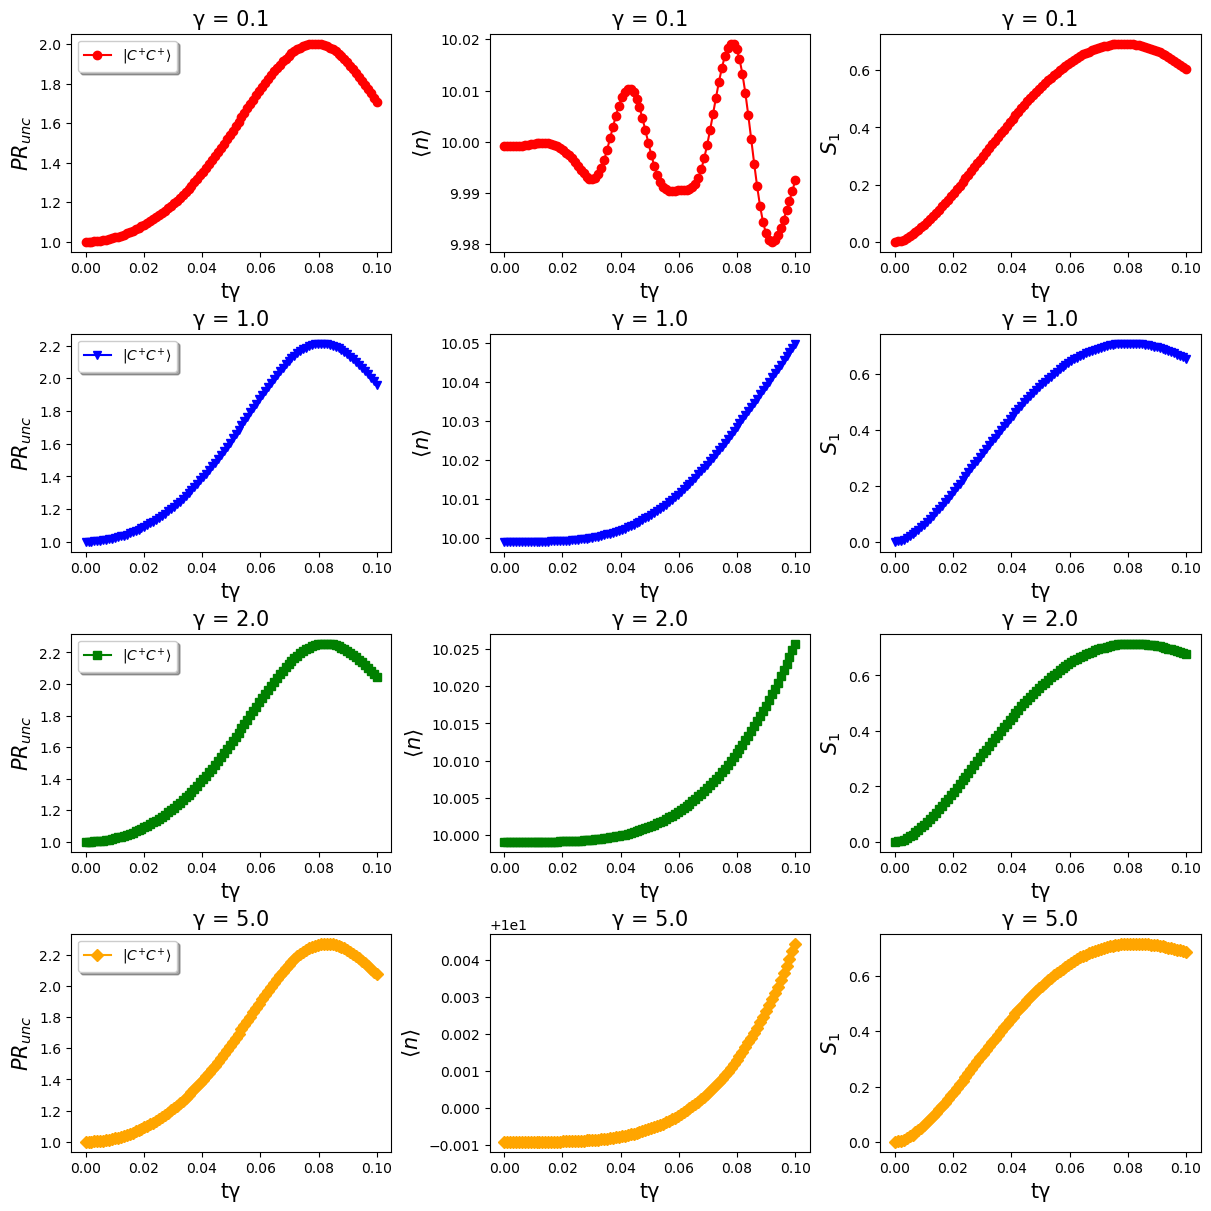

In [13]:
println("Loading data")
γs = [0.1, 1., 2., 5.]
ts_final = [0.1, 1., 5.] #These are τ = t * γ
println("Available τs = $(ts_final)")
t_step = 100
Entropies_γ = load("../data/Cat_dynamics/Entropy_p_$((Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22))_γs_τ.jld")["Entropies_γ"]
PRs_unc_γ = load("../data/Cat_dynamics/PR_unc_p_$((Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22))_γs_τ.jld")["PRs_unc_γ"]
ns_γ = load("../data/Cat_dynamics/ns_γ_$((Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22))_γs_τ.jld")["ns_γ"]
println("Done")

fig = figure(figsize=(12,12), layout= "constrained");
gs = fig.add_gridspec(length(γs),3);
element(i,j) = get(gs, (i,j)); # starts at 0 to N-1
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j);

colors_ = ["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"];
labels_ = Coupled_KPOs_QTB_functions.labels_states_KPOs(2);
markers_ = ["o", "v", "s", "D", "^", "<", ">", "p", "*", "h"];
labels_plots = [L"PR_{unc}", L"⟨n⟩", L"S_{1}"]
plots_list = [PRs_unc_γ, ns_γ, Entropies_γ] 
t_index = 1
log_scale = false

for j in 1:length(γs)
    for i in 1:3
        
        ax = fig.add_subplot(element(j-1,i-1));
        plot(range(0.0, ts_final[t_index], length=t_step), plots_list[i][j][t_index], marker = markers_[j], color=colors_[j], label = labels_[1])
        if i == 1
            legend(fontsize=10, shadow=true, loc = "upper left");
        end
        if log_scale == true
            xscale("log")
            yscale("log")
            ylabel( "log("* labels_plots[i] *")", fontsize=15);
            xlabel("log(tγ)", fontsize=15);
        else
            ylabel(labels_plots[i], fontsize=15);
            xlabel("tγ", fontsize=15);
        end
        title("γ = $(γs[j])", fontsize=15);
    end
end